In [1]:
import io
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import PIL
import torch
import torchvision
import urllib
import warnings

from skimage import color

from attacks import *


%load_ext autoreload
%autoreload 2

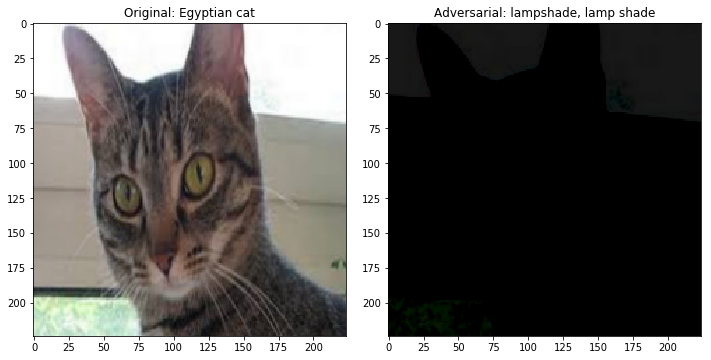

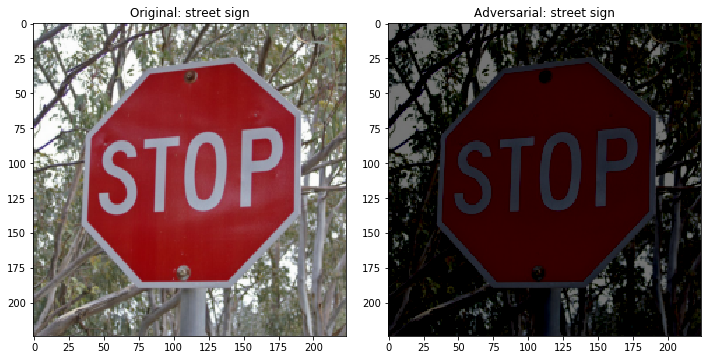

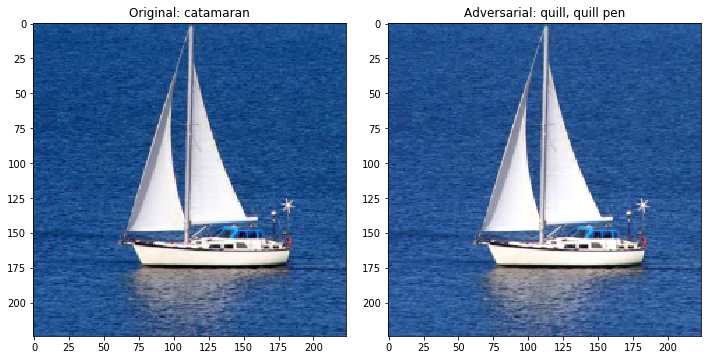

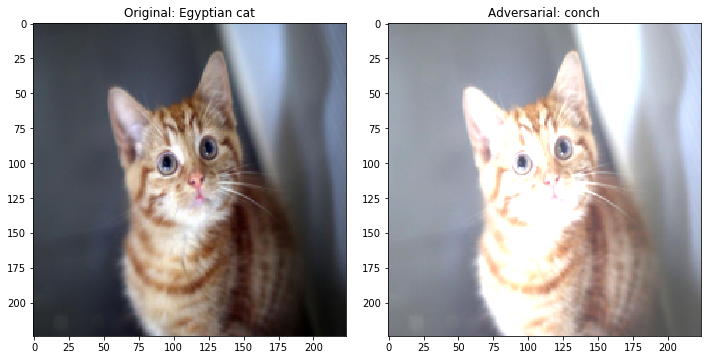

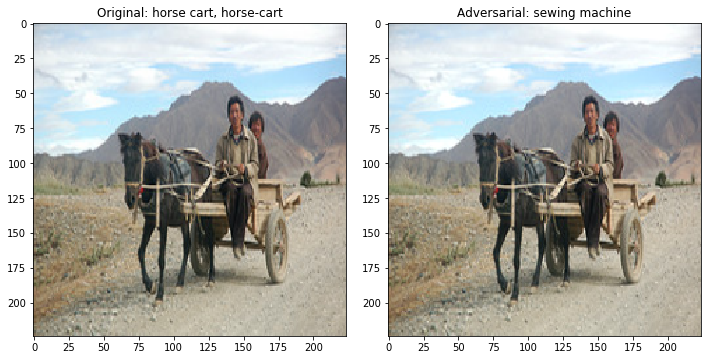

In [4]:
classif_model = load_classification_model('alexnet')
idx_to_label = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

def lab_relight(img, eps):
    img = img.transpose((2, 1, 0))
    img = torch.from_numpy(img).float().cuda()
    
    lab = rgb_to_lab(img).double()
    tmp1 = lab / torch.from_numpy(np.array([1.0, 1.0, 1.0]))[:, None, None].double().cuda()
    tmp2 = tmp1 + eps[:, None, None].cuda()
    torch.clamp(tmp2[0], 0, 100)
    rgb_image = torch.clamp(lab_to_rgb(tmp2) , 0, 1)
    
    return rgb_image
   
num_iterations = 20

y_target = torch.ones(1)
y_target *= 500
y_target = y_target.long().cuda()
        
data_path = './data'
for im_name in os.listdir(data_path):
    img = read_image(os.path.join(data_path, im_name))
    eps = torch.from_numpy(np.array([0.0, 0.0, 0.0]))
    eps.requires_grad = True
    
    with torch.no_grad():
        output = classif_model(preprocess_classifier_input(img))
        _, predicted_orig_label = torch.max(output, 1)
        
    
    for i in range(num_iterations):
        relit = lab_relight(img, eps)

        if i == num_iterations - 1:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            fig.tight_layout()
    
            axes[0].imshow(img)
            axes[1].imshow(relit.detach().cpu().numpy().transpose((2, 1, 0)))
            
        norm_relit = normalize_classifier_input(relit.unsqueeze(0))
        classif_output = classif_model(norm_relit)
        _, predicted = torch.max(classif_output, 1)

        loss = torch.nn.CrossEntropyLoss(reduction='mean')(classif_output, y_target)
        zero_gradients(eps)

        if i == num_iterations - 1:
            axes[0].set_title('Original: %s' % idx_to_label[predicted_orig_label[0].item()])
            axes[1].set_title('Adversarial: %s' % idx_to_label[predicted[0].item()])
            
        loss.backward()
        new_eps = eps.clone().detach()
        new_eps[0] -= 50 * eps.grad[0]
        eps = new_eps
        eps.requires_grad = True